In [146]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import math as math
from scipy.stats import chisquare

In [277]:
def powerlaw(r, s0, b):  
    # r0 no es variable aleatoria
    r0 = 300
    return s0*(r0/r)**(b)

def baricentro(signal,det_pos):
    sum_s = 0
    bari_x = 0
    bari_y = 0
    for i in range(len(det_pos)):
        
        if signal[i] > 2:
            bari_x += signal[i]*det_pos[i][0]
            bari_y += signal[i]*det_pos[i][1]
            sum_s  += signal[i]
            
    return(bari_x/sum_s,bari_y/sum_s)
    


#estimacion inicial del core es el baricentro

def funcion_costo2(theta,x_pos,y_pos,signal_sim,zenith,azimuth,ysigma):

        s0 = theta[0]
        b = theta[1]
        x_core = theta[2]
        y_core = theta[3]
        
        costo = np.zeros_like(s0)

        for (dist_x,dist_y,y1,sigma1) in zip(x_pos,y_pos,signal_sim,ysigma):
            
            dist = getDistances(dist_x,dist_y,x_core,y_core,zenith,azimuth)[0]
            yfit = powerlaw(dist, s0, b)
            residuo = y1 - yfit
            z = (residuo / sigma1)
            costo += z*z

        return costo
    
costo2 = lambda theta: funcion_costo2(theta,x_det,y_det,y_random1,zenith,azimuth,sigma) 

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point

def getDistances(xpositions, ypositions, x0=0, y0=0, zenithRad=0, azimuthRad=0):

    dx = xpositions - x0    # detector wrt core positions
    dy = ypositions - y0
    
    groundDistances = np.sqrt(dx*dx+dy*dy)

    # Direction cosines in the plane xy
    dirx =  math.cos(azimuthRad)
    diry =  math.sin(azimuthRad)

    axisProjections = math.sin(zenithRad) * (dx*dirx+dy*diry)
    
    distances = np.sqrt( groundDistances**2 - axisProjections**2 )
    
    return (distances,axisProjections,groundDistances)

def simZenith(zenithMinDeg, zenithMaxDeg) :

    zenithMinRad = math.radians(zenithMinDeg)
    sin2MinZenith = math.sin(zenithMinRad)**2

    zenithMaxRad = math.radians(zenithMaxDeg)
    sin2MaxZenith = math.sin(zenithMaxRad)**2

    rng = np.random.default_rng()
    u = rng.random() 
    
    sin2Zenith = sin2MinZenith + u * (sin2MaxZenith-sin2MinZenith)
    sinZenith = math.sqrt(sin2Zenith) 

    zenith = math.asin(sinZenith)
    azimut = np.random.uniform(0,2*np.pi)
    
    return (zenith,azimut)

poligono = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0]]
detectores_pos = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0],[0,0]]
rectangulo = [[-433,-375],[433,-433],[433,375],[-433,375]]
pointsx,pointsy = [-216.5,216.5,433,216.5,-216.5,-433.5,0] , [-375,-375,0,375,375,0,0]
random_point = in_hex(poligono)
centro = (0,0)
x_det = np.zeros(len(detectores_pos))
y_det = np.zeros(len(detectores_pos))
for i in range(len(detectores_pos)):
    x_det[i] = detectores_pos[i][0]
    y_det[i] = detectores_pos[i][1]

In [441]:
#Defino parametros de LDF 
r0 = 300 #metros 
s0 = 35 #VEM
angulo = 0
zenith = simZenith(-angulo,angulo)[0]
azimuth = simZenith(-angulo,angulo)[1]
b = 2.1    

#Genero el punto random
random_point = in_hex(poligono)

#calculo las distancias entre el evento y los 7 detectores.
distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
r = np.asarray(distancias[0])

signal = powerlaw(r,s0,b)
sigma_signal = np.sqrt(signal)

#Hago el ajuste y defino la semilla inicial
y_random = np.random.normal(signal,sigma_signal,size = len(signal)) #signal
y_random = y_random[y_random > 2]
sigma = np.sqrt(y_random)

core_est_x = baricentro(y_random,detectores_pos)[0] 
core_est_y = baricentro(y_random,detectores_pos)[1] 

In [222]:
res = minimize(costo2, x0=(30,1,core_est_x,core_est_y))
#print(res)
print('Minimize results')
print("Parametros ajustados: ", res.x)
cova = 2*res.hess_inv
par_error = np.sqrt(np.diagonal(cova))
print('Errores de los parámetros', par_error)
print(cova)

Minimize results
Parametros ajustados:  [ 36.01897123   2.19168713  96.70750247 342.35205989]
Errores de los parámetros [3.07409078 0.12942122 4.24135265 1.55228872]
[[ 9.45003413e+00 -1.94421201e-01 -1.05622566e+01  3.37047950e+00]
 [-1.94421201e-01  1.67498516e-02  8.81421690e-02 -2.81857382e-02]
 [-1.05622566e+01  8.81421690e-02  1.79890723e+01 -6.29135901e+00]
 [ 3.37047950e+00 -2.81857382e-02 -6.29135901e+00  2.40960026e+00]]


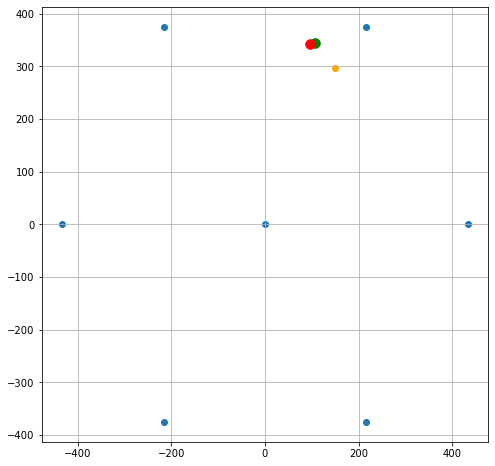

In [223]:
plt.figure(figsize=(8,8))
plt.scatter(pointsx,pointsy)
plt.scatter(core_est_x,core_est_y,c='orange')
plt.scatter(random_point[0],random_point[1],s = 90,c='green')
plt.scatter(res.x[2],res.x[3],s = 90,c='red')
plt.grid()


In [224]:
random_point,(res.x[2],res.x[3]),getDistances(random_point[0],random_point[1],res.x[2],res.x[3],0,0)[0],res.success

((106.88722120801049, 344.82926247050636),
 (96.70750246854922, 342.35205988901686),
 10.476793700568754,
 True)

In [453]:
tries = 5000

dif_est_x = np.zeros(tries)
dif_est_y = np.zeros(tries)

Falso = 0
Verd = 0

puntos_x = []
puntos_y = []

error = np.zeros(tries)

resultados_f = []
resultados_t = []

for i in range(tries):
    #Genero el punto random
    random_point = in_hex(poligono)
    puntos_x.append(random_point[0])
    puntos_y.append(random_point[1])
    
    #calculo las distancias entre el evento y los 7 detectores.
    distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
    r = np.asarray(distancias[0])

    signal = powerlaw(r,s0,b)
    sigma_signal = np.sqrt(signal)

    #Hago el ajuste y defino la semilla inicial
    y_random = np.random.normal(signal,sigma_signal,size = len(signal)) #signal
    y_random1 = y_random[y_random > 2]

    sigma = np.sqrt(y_random1)

    core_est_x = baricentro(y_random,detectores_pos)[0] 
    core_est_y = baricentro(y_random,detectores_pos)[1] 
    
    res = minimize(costo2, x0=(30,1,core_est_x,core_est_y))
    
    if res.success == True:
        error[i] = np.sqrt((res.x[2] - random_point[0])**2 + (res.x[3] - random_point[1])**2)
        dif_est_x[i] = res.x[2]
        dif_est_y[i] = res.x[3]
        Verd += 1
        if error[i] > 100:
            resultados_t.append(res)
            
            
    if res.success == False:
        resultados_f.append(res)
        Falso += 1 
        dif_est_x[i] = res.x[2]
        dif_est_y[i] = res.x[3]
        #plt.figure(figsize=(8,8))
        #plt.scatter(pointsx,pointsy)
        #plt.scatter(core_est_x,core_est_y)
        #plt.scatter(random_point[0],random_point[1],s=90,c='green')
        #plt.scatter(res.x[2],res.x[3],s=90,c='red')
        #break
        

        

/Users/gunitettamanti/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/gunitettamanti/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
<ipython-input-277-fee6b3c72f2b>:38: RuntimeWarning: overflow encountered in double_scalars
  costo += z*z
/Users/gunitettamanti/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in subtract
  df = (f(*((xk + d,) + args)) - f0) / d[k]
<ipython-input-277-fee6b3c72f2b>:38: RuntimeWarning: overflow encountered in double_scalars
  costo += z*z
/Users/gunitettamanti/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


(0.0, 2000.0)

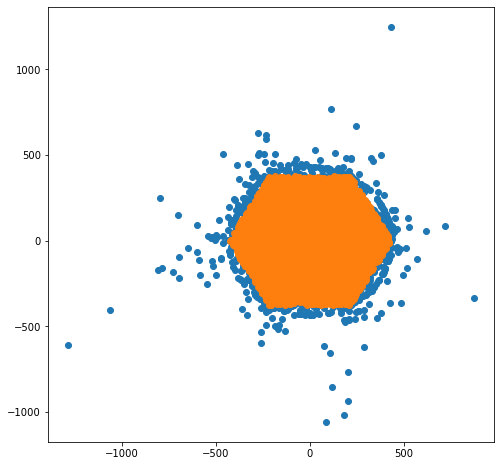

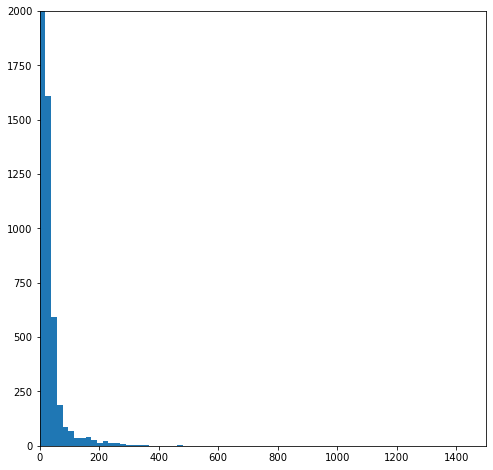

In [457]:
plt.figure(figsize=(8,8))
plt.scatter(dif_est_x,dif_est_y)
plt.scatter(puntos_x,puntos_y,alpha = 0.9)
plt.figure(figsize=(8,8))
plt.hist(error,bins=50)
plt.xlim(0,1500)
plt.ylim(0,2000)

In [455]:
Falso/(Verd+Falso)

0.1138

In [458]:
np.max(error)

963.1077589264347